In [1]:
%matplotlib inline

import sys
import os
from os.path import join
from pathlib import Path
sys.path.append(join(Path(os.getcwd()).parent, 'lib'))
import pandas as pd
import numpy as np
import json
import collections
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (15,7)
from importlib import reload
from  mainlib import fasorial, lista, sdict, mm, mm_sep
from of_proc import *

def plotar(batch):  
    for n,c in enumerate(batch):
        ax, s = plt.subplots()
        title = deg(mm[c].rolling(window=100).mean())     
        mm[c].plot(title=str(c)+'_'+str(title))
        mm[c].rolling(window=100).mean().plot()

def div_batch(x, n_batches):
    l=[]
    batch_size = int(len(x)/n_batches)
    for i in range(0, n_batches*batch_size, batch_size):
        l.append(x[i:i+batch_size])
    l.append(x[(batch_size*n_batches-1):])
    return l

def ps(x):
    return pd.Series(x)


Using TensorFlow backend.


In [2]:
def read_info(path, tem_perfil_funcionamento):
    global PATH, OUTPUT_PATH, PROCESSED_PATH, PERFIS_PATH, HORARIOS_PATH, PATH_MM, PATH_FAS, \
    DEG, MOR, PER, FAS, OUTPUT_HEADER,FAS_CONCAT, MM_CONCAT, PICKLES_CONCAT, OUT_INDEX, COLS_LISTA, \
    OUT, DATA_DIR, LISTA_CAD_PATH, PROCESSADOS_PICKLE, ERROS_PICKLE, LOGS_DIR, ADJACENCIAS_PATH
    with open(path) as f:
        info = json.load(f)
        PATH_FAS = info['paths']['fasoriais2']['input']
        PERFIS_PATH = info['paths']['perfis']['perfis']
        HORARIOS_PATH = info['paths']['perfis']['horarios']
        PATH_MM = info['paths']['mm']['input']
        DEG = info['paths']['nn_models']['degrau']
        MOR = info['paths']['nn_models']['morro']
        PER = info['paths']['nn_models']['perfil']
        FAS = info['paths']['nn_models']['fasorial']
        COLS_LISTA = info['lista2']['columns']  
        OUTPUT_HEADER = info['output']['header']
        OUT_INDEX = info['output']['header']
        OUT = info['paths']['output']
        DATA_DIR = info['paths']['base_dir']
        LISTA_CAD_PATH = info['paths']['lista']
        PROCESSADOS_PICKLE = info['paths']['processados']
        ERROS_PICKLE = info['paths']['erros']
        LOGS_DIR = info['paths']['logs']
        if tem_perfil_funcionamento:
            ADJACENCIAS_PATH = info['paths']['adjacencias']

In [3]:
json_file = '../../info/info-EDP-ES.json'
tem_perfil_funcionamento = False

In [4]:
read_info(json_file, tem_perfil_funcionamento)

In [5]:
global df_mm_new
mmm = mm(json_file)
df_mm_new = pd.read_csv(PATH_MM,date_parser = mmm.dateparser, index_col=[0], sep=';')

In [6]:
with open(json_file,'rt') as p:
    data = json.load(p)

mm_path = data['paths']['mm']['input']
df_mm = pd.read_csv(mm_path, sep=';', index_col = 0, parse_dates=[0])
df_mm.fillna(value=0, inplace=True)
l = div_batch(df_mm.columns, 60)

In [7]:
COLS_LISTA = data['lista2']['columns']
LISTA_CAD_PATH = data['paths']['lista']

try:
    LISTAF = pd.read_csv(LISTA_CAD_PATH, names = COLS_LISTA, header=0, sep=';',engine='python')
except:
    LISTAF = pd.read_csv(LISTA_CAD_PATH, names = COLS_LISTA, header=0, engine='python')

In [8]:
LISTAF['instalacao'] = pd.DataFrame(LISTAF['instalacao'].apply(lambda x: '{0:0>10}'.format(x)))
try:
    LISTAF['medidor'] = pd.DataFrame(LISTAF['medidor'].astype(int).apply(lambda x: '{0:0>8}'.format(x)))
except:    
    LISTAF['medidor'] = pd.DataFrame(LISTAF['medidor'].apply(lambda x: '{0:0>8}'.format(x)))

In [9]:
faltantes = ['0000795621']

In [10]:
LISTAF = LISTAF[LISTAF['instalacao'].isin(faltantes)]

In [11]:
LISTA_CAD = get_list(json_file)
LISTA_CAD.df =  LISTAF
if tem_perfil_funcionamento:
    HORARIOS, PERFIS, ATIVS = get_horario_info2(json_file)
dim, dmi = dicts(LISTA_CAD)

In [12]:
list_columns_remove = ['cliente', 'medidor', 'data_inicio', 'data_fim', 'lote', 'ssn', 'troca']
cols = list(LISTA_CAD.df.columns[~LISTA_CAD.df.columns.isin(list_columns_remove)==True])
del(cols[1])
cols_without_instal = cols.copy()
del(cols_without_instal[0])
troca = False
o_i_normal = collections.OrderedDict(sorted(LISTA_CAD.mes_days(troca, cols).items()))
troca = True
o_i_troca = collections.OrderedDict(sorted(LISTA_CAD.mes_days(troca, cols).items()))
o_instas =  collections.OrderedDict(sorted({**o_i_normal, **o_i_troca}.items()))

In [13]:
LISTAF

,cliente,instalacao,medidor,data_inicio,data_fim,lote,ssn,5,6,7,8,troca
601,HIDRA HAIR INDUSTRIA E COMERCIO DE COSME,0000795621,00008967,01/01/2015,31/12/2099,NaN,89550532220006137284,07/05/2019,04/06/2019,04/07/2019,05/08/2019,1-Sem troca de medidor


In [14]:
def integrate(y_vals, h):
    i = 1
    total = y_vals[0] + y_vals[-1]
    for y in y_vals[1:-1]:
        if i % 2 == 0:
            total += 2 * y
        else:
            total += 4 * y
        i += 1
    return total * (h / 3.0)

{6: Timestamp('2019-06-04 00:00:00'), 7: Timestamp('2019-07-04 00:00:00'), 8: Timestamp('2019-08-05 00:00:00')}
6 False
7 False


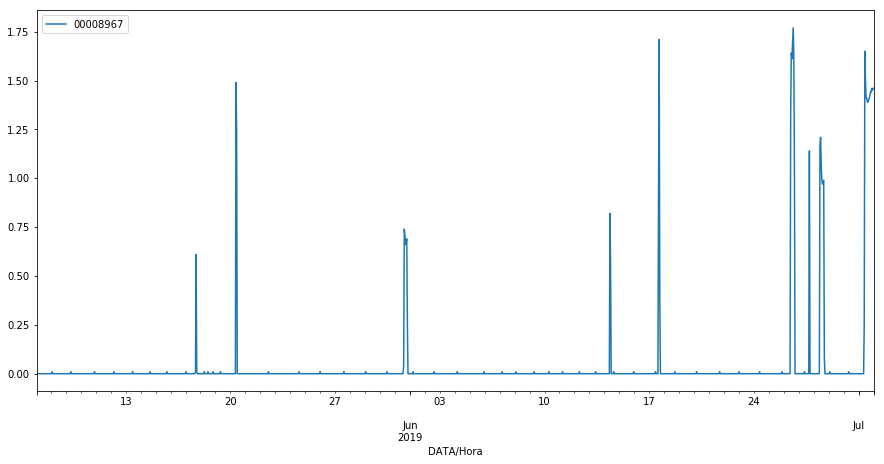

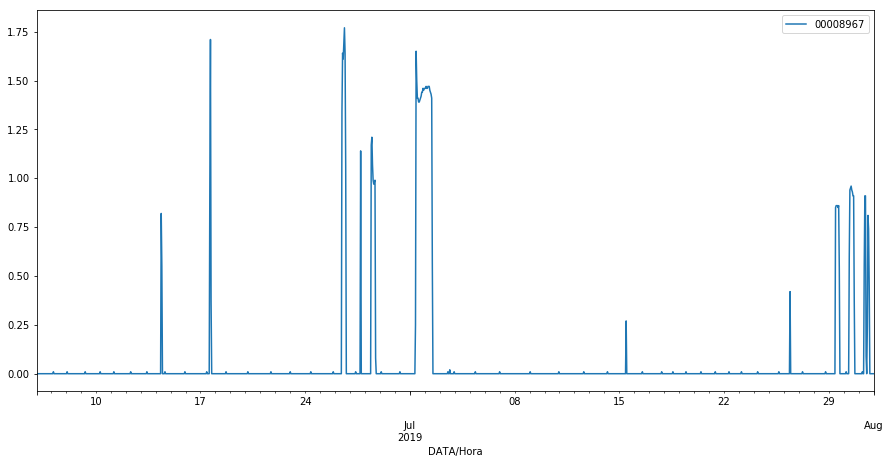

In [15]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = (15,7)
morro = pd.DataFrame(columns=['mes', 'instalacao', 'medidor'])
for index, row in LISTAF[['instalacao', 'medidor', 5, 6, 7, 8, 'troca']].drop_duplicates().iterrows():
    instalacao = row['instalacao']
    medidor = row['medidor']
    if tem_perfil_funcionamento:
        ramo = percats[instalacao] if instalacao in percats else 0
    else:
        ramo = 0
    
    ddays = o_instas[instalacao] if instalacao in o_instas else default_ddays_2()
    dmm = mm(json_file, name = instalacao, ddays = ddays, ramo=ramo)
    
    dmm.df = pd.DataFrame(df_mm[medidor])
    dmm.proc_mm()
    dmm.split_months(json_file, ddays = ddays, four_weeks = True)
    dmm.eight_weeks(json_file, ddays = ddays)
    dmm.eight_weeks(json_file, ddays = ddays, tipo = 'morro')  
    interval = 1
    window = 24
    for y in dmm.bimestres['morro']:
        for b in dmm.bimestres['morro'][y]:
            min_area = 999999999
            max_area = 0
            tem_morro = False
            count_descida = 0
            df_tmp = dmm.bimestres['morro'][y][b].df
            max_i_area = len(df_tmp)
            i = 0
            while i < len(df_tmp):
                area = integrate(df_tmp.iloc[i:i+window].values, interval)
                if area < min_area:
                    min_area = area
                if area > max_area:
                    max_i_area = i
                    max_area = area
                i = i + window  
            i = max_i_area + 1   
            max_count_descida = 0
            while i < len(df_tmp):       
                area = integrate(df_tmp.iloc[i:i+window].values, interval)
                if (max_area >= min_area * 3) and (3*area <= max_area):
                    count_descida = count_descida + 1
                    if count_descida > max_count_descida:
                        max_count_descida = count_descida
                    #print('mes', b)    
                    #print('i', i)
                    #print('i + window', i+window)
                    #print("min area", min_area)
                    #print("max area", max_area)
                    #print('area', area)
                else:
                    count_descida = 0
                i = i + window    
            if count_descida >= 2:
                print(count_descida)
                tem_morro = True
            print(b, tem_morro)
            df_tmp.plot()

In [ ]:
dmm.bimestres['morro'][2019][7].df

In [ ]:
LISTAF = LISTAF[LISTAF['instalacao'].isin(faltantes)].sort_values(by=['medidor'], ascending=False).head(1)

In [ ]:
df = pd.DataFrame(mm[LISTAF['medidor']])

In [ ]:
df.index.name = 'time'
df.columns = ['mm']

In [ ]:
df['media_movel'] = df['mm'].rolling(window=10).mean()

In [ ]:
acima_media_movel = df[df['mm'] > df['media_movel']]

In [ ]:
max_date_media_movel = acima_media_movel.idxmax()['mm']

In [ ]:
abaixo_media_movel = df[(df['mm'] < df['media_movel']) & (df.index > max_date_media_movel)]

In [ ]:
threshold_count = 48
if len(abaixo_media_movel) > threshold_count and len(acima_media_movel > threshold_count)
    

In [ ]:

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import read_csv
from pandas import datetime

df.plot()

stl = seasonal_decompose(df, freq=24*4, model='additive')
fig = stl.plot()
fig.set_size_inches(15, 7)


df_resid = stl.resid
df_seasonal = stl.seasonal
df_trend = stl.trend

In [ ]:
df_resid = pd.DataFrame(df_resid, columns = ['mm'])

In [ ]:
pd.DataFrame(df_resid, columns = ['mm'])

In [ ]:
df_resid.notna()

In [ ]:
mean = np.mean(df_resid['mm'])

In [ ]:
mean

In [ ]:
std = np.std(df_resid, ddof=1)

In [ ]:
df_resid

In [ ]:
mean = np.mean(df_resid['mm'])
std = np.std(df_resid['mm'], ddof=1)
df_resid['STD'] = (df_resid- mean) / std

df_resid['outlier'] = np.where(((df_resid['STD']>3) | (df_resid['STD']<-3)), df, 0)
df_anom = df_resid[(df_resid['outlier'] != 0)]


# Calculo share de anomalias
base_count = df.shape[0] # count() nao retorna os NAN
anom_count = df_anom.shape[0]
anom_share = anom_count / base_count
print("{0:.2f}%".format(float(anom_share) * 100)) # share de anomalias

fig, ax = plt.subplots()
df.plot(color = 'red', linestyle='dashed', linewidth = 0.5, x=ax)
df_anom['outlier'].plot(style='bo', ax=ax)

plt.xlabel('Time')
plt.ylabel('mm')
plt.title('Count vs Time | '+ str("{0:.2f}%".format(float(anom_share) * 100)) + ' de Anomalias')
plt.subplots_adjust(bottom=0.2)

fig = plt.gcf()
fig.set_size_inches(20, 10)

In [ ]:
residual[residual > 5]

------

In [ ]:
df['2019-06-05 00:00:00':'2019-06-05 23:59:59']

In [ ]:
def aglut(*args):
    lo = args[0].copy()
    for l in args[1:]:
        lo.extend(l)
    return lo

In [ ]:
def deg(x,o='left'):
    h1 = x[int(len(x)/2):].mean()
    h2 = x[:int(len(x)/2)].mean()
    if h1 > h2 * factor:
        a = 1 
    elif h1 < h2 / factor:
        a = -1        
    else:
        a=0
    if len(x)>=limite:  
        if o == 'right':
            return aglut([a], deg(x[int(len(x)/2):], o = 'right'))
        else:
            return aglut(deg(x[:int(len(x)/2)]), [a])    
    else:
        return [a]

In [ ]:
def plotar2(mm, n):  
    for i in range(n):
        cols = mm.columns        
        v = int(np.random.sample() * len(cols) )
        s0 = mm[cols[v]]
        s1 = mm[cols[v]].clip(0,mm[cols[v]].quantile(0.99))
        s2=s1.rolling(window=500).mean().dropna()
        title = (aglut(deg(s1.rolling(window=500).mean().dropna()), deg(s1.rolling(window=500).mean().dropna(), o = 'right')))
        if cv(title):
            ax, s = plt.subplots()
            s0.plot()
            s1.plot()
            s2.plot(title=str(title))        

In [ ]:
def cv(x):
    se0, se1, se2 = False, False, False
    for i in x:
        if se2:
            return 1
        if i == 0:            
            se0 = True
            if se1:
                se2 = True   
        elif i == -1 and se0:
            se1 = True   
        elif i == 1:
            return 0
    return 0

In [ ]:
def cv2(x):
    se0, se1, se2 = False, False, False
    for i in x:
        if se2:
            return 1
        if i == 0:            
            se0 = True 
        elif i == -1 and se1:
            se2 = True
        elif i == 1 and se0:
            se1 = True   
    return 0

In [ ]:
factor=1.3
limite=int(mm.shape[0]/512)
plotar2(mm, 50)